# Build Ensembler for ensemble prediction using pre-trained models

In [1]:
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

#from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# ###############################################################################
# Load data
# ###############################################################################
def load_data(f_name,bin=False):
    if DATA_LOC == 'local':
        #os.chdir('D:/MIDS/W266/Project/Data/')
        #file_path = 'D:/MIDS/W266/Project/Data/'
        if bin:
            file_path = 'D:/MIDS/W266/Project/Data/Bin/'
        else:
            file_path = 'D:/MIDS/W266/Project/Data/'
    else:
        file_path = "/content/drive/My Drive/w266/data/"

    data = pya.parquet.read_table(file_path+f_name)
    df = data.to_pandas()

    return(df)

In [8]:
# #########################################
# DEVELOP spaCy MODELS
# #########################################
!pip install spacy --quiet
!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")
spacy_limit = 1000000

Defaulting to user installation because normal site-packages is not writeable
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# ##############################################################################
# Use spacy to find and replace person names
#
# keep
#    0: find name and remove
#    1: replace name and keep 
#
# replace
#    text to replace name with
# ##############################################################################
def perform_NER(text, keep = True, replace = 'PERSON'):
    modified_tokens = []
    
    doc = nlp(text)
    for token in doc:
        #print(token.text)
        #print(token.ent_type_)
        if token.ent_type_ == 'PERSON': #in ('PERSON'):  # 'GPE', 'WORK_OF_ART'
            if (keep):
                modified_tokens.append(replace + token.whitespace_)
        else:
            #print(token.text)
            modified_tokens.append(token.text_with_ws)
            #print(modified_tokens)
    doc_wo_names = ''.join(modified_tokens)
    #print(doc_wo_names)
    return(doc_wo_names)

def get_NER_data(df_data, keep = True, replace = 'PERSON'):
    data  = []
    label = []
    
    for indx, row in df_data.iterrows():
        data.append(perform_NER(row[0], keep=keep, replace=replace))
        #data.append(row[0])
        label.append(row[1])
        
    return (data,label)

# Without using NER
def get_data(df_data):
    data  = []
    label = []
    
    for indx, row in df_train.iterrows():
        data.append(row[0])
        label.append(row[1])
        
    return (data,label)

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def create_confusion(test, pred, type='probabilities'):
    prediction_max = []
    
    if type == 'probabilities':
        for i in range(len(pred)):
            prediction_max.append(np.argmax(pred[i]))
    else:
        prediction_max = pred
    
    # *********************************************************************************
    # Metrics from Training
    #
    # when called after Training, is the last known values
    # *********************************************************************************
    # Calculate accuracy using TensorFlow
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(test, prediction_max)
    accuracy_result = accuracy.result().numpy()
    
    # Calculate precision, recall, and F1 score using TensorFlow
    precision = tf.keras.metrics.Precision()
    precision.update_state(test, prediction_max)
    precision_result = precision.result().numpy()

    recall = tf.keras.metrics.Recall()
    recall.update_state(test, prediction_max)
    recall_result = recall.result().numpy()

    f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)
    
    #print("\nAccuracy:", accuracy_result)
    #print("\nPrecision:", precision_result)
    #print("Recall:", recall_result)
    #print("F1 Score:", f1)
    # *********************************************************************************
    
    # *********************************************************************************
    # Generate confusion matrix from Test set
    #
    # Rows are Actuals (Test labels)
    # Cols are prericted values
    #
    # FN measured across row
    # FP measured down column
    # *********************************************************************************
    conf_matrix = confusion_matrix(test, prediction_max)
    
    # Print confusion matrix and metrics
    print("Confusion Matrix:")
    print(conf_matrix)

    # Classification report using scikit-learn
    class_report = classification_report(test, prediction_max)
    print("\nClassification Report:")
    print(class_report)
    
    return(conf_matrix)

def show_confusion(conf_matrix):
    # Set row labels
    class_labels = ["Fitzgerald", "Hemingway", "Hardy", "Dickens", "Austen", "Chesterton", "Shakespeare"]
    
    # Confusion matrix with counts
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Confusion matrix as percentage of counts
    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with Percentages")
    plt.show()
    
    #####################################################

In [124]:
MAX_SEQUENCE_LENGTH = 128
DATA_LOC = 'local'  # set to local or remote
SEED_VALUE = 42

# clear any old model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(SEED_VALUE)

In [125]:
# ##########################################################
# RoBERTa Model
# ##########################################################
from transformers import TFRobertaModel , RobertaTokenizer

checkpoint = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

In [13]:
def create_encoding(data, label, tokenizer):
  data_encodings = tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)
  # label_encodings = torch.tensor(label)

  return (data_encodings, label_encodings)

# Define Models

In [14]:
# Create RoBERTa with CNN
# multi-modal or multi-channel approach, where the RoBERTa model processes the input text,
# and the CNN layer processes the sequential embeddings produced by RoBERTa.
# This can be beneficial when you want to capture local patterns and relationships
# in addition to the global contextual information provided by the transformer model.
def create_roberta_cnn(num_train_layers=0,
                       num_classes=2,
                       hidden_size=50,
                       dropout=0.1,
                       learning_rate=0.001,
                       lr_schedule=False,
                       type='multi'):
    
  roberta_model  = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    roberta_model.trainable = False
  elif num_train_layers == 12:
    # Train all layers of the BERT model
    roberta_model.trainable = True
  else:
    # Restrict training to the num_train_layers outer transformer layers
    layers_to_train = roberta_model.layers[-num_train_layers:]
    for layer in layers_to_train:
      layer.trainable = True

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

  roberta_out = roberta_model(inputs)[0]  # Extract the last hidden state

  cnn_layers = [
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',name='CNN1'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='CNN2'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name='CNN3'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', name='CNN4'),
        tf.keras.layers.MaxPooling1D()
  ]

  cnn_out = roberta_out
  for layer in cnn_layers:
      cnn_out = layer(cnn_out)

  # Global max pooling layer to reduce dimensionality
  cnn_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)

  cnn_out = tf.keras.layers.Flatten()(cnn_out)

  # Dense layer for classification
  #output = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output layer')(pooled_out)

  # Fully connected layers for classification
  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)
  #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden)

  if type == 'multi':
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)
  else:
    classification = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='classification_layer')(hidden)

  roberta_cnn_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  # Exclude non-trainable variables from the list of trainable variables
  #trainable_vars = [var for var in roberta_cnn_model.trainable_variables if 'pooler' not in var.name]

  # Use a learning rate scheduler
  if (lr_schedule):
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100,  # Adjust this value based on your preference
      decay_rate=0.9,     # Adjust this value based on your preference
      staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  if type == 'multi':
    roberta_cnn_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])
  else:
    roberta_cnn_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=['accuracy'])

  return roberta_cnn_model

# Load and Prepare Test Data

In [51]:
def save_prediction(loc, pred):
    np.savetxt(loc, pred)

# Load Models and Run Prediction

## RoBERTa Binary

In [47]:
# ###########################################################################
# RoBERTa Binary
# ###########################################################################
if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    wgt_path = 'D:/MIDS/W266/Project/Training/Bin/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/bin/'

wgt_files = ['roberta_bin_bal_NER_nokeep_0_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_1_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_2_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_3_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_4_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_5_weights_epoch0_Case13.h5',
             'roberta_bin_bal_NER_nokeep_6_weights_epoch0_Case13.h5'
            ]

predictions = []


# #########################################################################
# Load test data
# #########################################################################
test_filenames = ['test_case13_bin_0.parquet',
                  'test_case13_bin_1.parquet',
                  'test_case13_bin_2.parquet',
                  'test_case13_bin_3.parquet',
                  'test_case13_bin_4.parquet',
                  'test_case13_bin_5.parquet',
                  'test_case13_bin_6.parquet'
                 ]

for indx in range(len(wgt_files)): #, wgt_file in wgt_files:
    # clear any old model parameters
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED_VALUE)
    model = create_roberta_cnn(num_classes=1,
                                dropout=0.2,
                                num_train_layers=4,
                                learning_rate=0.0001,
                                hidden_size=128,
                                lr_schedule=False,
                                type='bin')

    model.load_weights(wgt_path+wgt_files[indx])
    df_test = load_data(test_filenames[indx],bin=True)
    test_data_NER, test_label_NER = get_NER_data(df_test,keep=False)
    test_encodings_roberta, test_enc_label_roberta = create_encoding(test_data_NER, test_label_NER, roberta_tokenizer)
    
    # Run prediction
    prediction = model.predict([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask])
    predictions.append(prediction)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 562s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 582s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 619s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 573s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 583s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 631s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

214/214 [==============================] - 581s 3s/step


In [52]:
#save_prediction
for indx, prediction in enumerate(predictions):
    path = 'D:/MIDS/W266/Project/Prediction/'
    file = 'roberta_bin_prediction_' + str(indx)
    save_prediction(path+file,prediction)

In [56]:
threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions[3] >= threshold).astype(int)

Accuracy: 0.9148407829389424
Precision: 0.7384007897334649
Recall: 0.701688555347092
F1-score: 0.7195767195767195


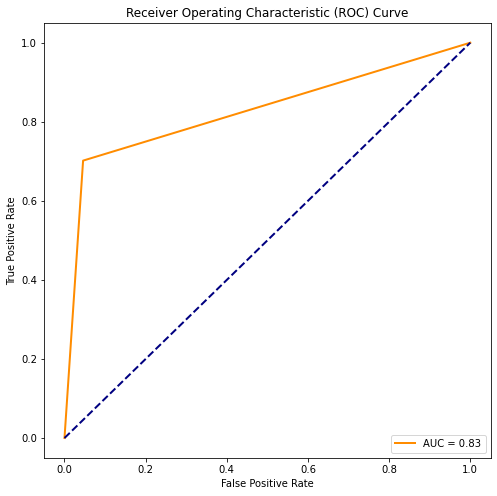

In [43]:
# *** UNIT TEST ***
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

threshold = 0.5

# Convert probabilities to binary predictions
binary_predictions = (predictions[3] >= threshold).astype(int)

#print("Binary Predictions:")
#print(binary_predictions[60:90])

accuracy = accuracy_score(test_label_NER, binary_predictions)
precision = precision_score(test_label_NER, binary_predictions)
recall = recall_score(test_label_NER, binary_predictions)
f1 = f1_score(test_label_NER, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

fpr, tpr, thresholds = roc_curve(test_label_NER, binary_predictions)
roc_auc = roc_auc_score(test_label_NER, binary_predictions)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## RoBERTa Multiclass 

In [126]:
# ###########################################################
# Load test data for multiclass models
# ###########################################################
#test_filename = 'test_case13.parquet'
test_filename = 'test_case14.parquet'
df_test = load_data(test_filename,bin=False)

# Create Test NER
test_data_NER, test_label_NER = get_NER_data(df_test,keep=False)

In [127]:
df_train = load_data('train_bal_case14.parquet',bin=False)
train_data_NER, train_label_NER = get_NER_data(df_train,keep=False)

In [138]:
# ###########################################################
# RoBERTa Multiclass Run Prediction
# ###########################################################
if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    wgt_path = 'D:/MIDS/W266/Project/Training/Best/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/'

wgt_file = 'roberta_multi_bal_Case14_weights_epoch2.h5'

test_encodings_roberta, test_enc_label_roberta = create_encoding(test_data_NER, test_label_NER, roberta_tokenizer)

tf.keras.backend.clear_session()
tf.random.set_seed(SEED_VALUE)
model = create_roberta_cnn(num_classes=7,
                            dropout=0.2,
                            num_train_layers=4,
                            learning_rate=0.0001,
                            hidden_size=128,
                            lr_schedule=False,
                            type='multi')

model.load_weights(wgt_path+wgt_file)

# Run prediction
prediction_roberta_multi = model.predict([test_encodings_roberta.input_ids, test_encodings_roberta.attention_mask])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

115/115 [==============================] - 407s 4s/step


In [ ]:
# ###########################################################
# RoBERTa Multiclass Load Saved Prediction
# ###########################################################

Confusion Matrix:
[[444   8  36  15   1  26   3]
 [ 10 270   4  14   0   5   3]
 [ 11   4 506  28  36  20   6]
 [  6   6 208 546 109  41  24]
 [  1   1  44  22 414   0   1]
 [ 48   2  32  18   2 234   1]
 [  2   0   4   5   1   0 452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       533
           1       0.93      0.88      0.90       306
           2       0.61      0.83      0.70       611
           3       0.84      0.58      0.69       940
           4       0.74      0.86      0.79       483
           5       0.72      0.69      0.71       337
           6       0.92      0.97      0.95       464

    accuracy                           0.78      3674
   macro avg       0.80      0.81      0.80      3674
weighted avg       0.80      0.78      0.78      3674



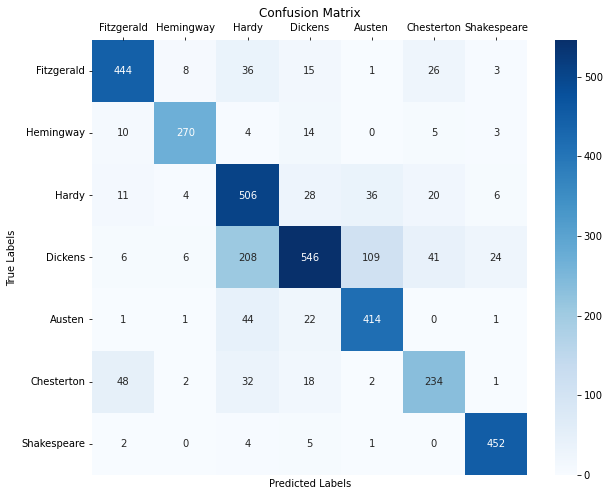

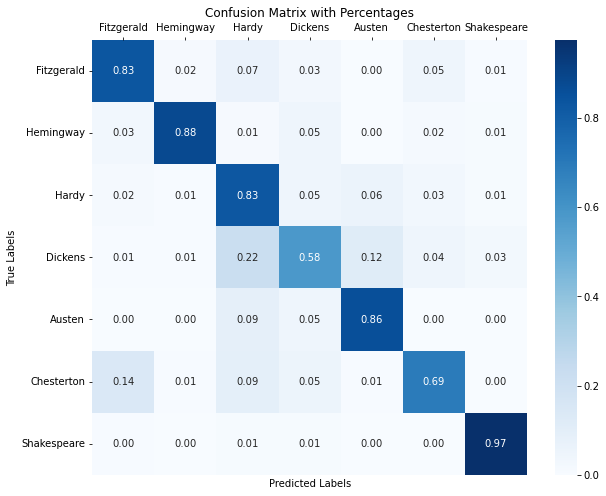

In [139]:
# Uncomment to Unit Test
c = create_confusion(test_label_NER, prediction_roberta_multi)
show_confusion(c)

In [77]:
#save_prediction
path = 'D:/MIDS/W266/Project/Prediction/'
file = 'roberta_multi_prediction'
save_prediction(path+file,prediction_roberta_multi)

## SGDClassifier 

In [128]:
# ###################################################################################
# Train SGDClassifier
# ###################################################################################
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_data_NER)
X_test_tfidf = vectorizer.transform(test_data_NER)
sgd_classifier = SGDClassifier(loss='log',penalty="l2", max_iter=100, random_state=42)

sgd_classifier.fit(X_train_tfidf, train_label_NER)

SGDClassifier(loss='log', max_iter=100, random_state=42)

In [130]:
# Save SGD Model
import pickle
with open('D:/MIDS/W266/Project/Training/Best/lr_model.pkl', 'wb') as f:
    pickle.dump(sgd_classifier, f)

with open('D:/MIDS/W266/Project/Training/lr_model_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [72]:
# ###########################################################
# SGDClassifier
# ###########################################################
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle

#vectorizer = TfidfVectorizer()
#X_test_tfidf = vectorizer.transform(test_data_NER)

#sgd_classifier = SGDClassifier(loss='log', max_iter=100, random_state=42)

# *********************************
# LOAD STORED WEIGHTS / MODEL
# *********************************
with open('D:/MIDS/W266/Project/Training/lr_model.pkl', 'rb') as file:
    sgd_model = pickle.load(file)

with open('D:/MIDS/W266/Project/Training/lr_model_vectorizer.pkl', 'rb') as file:
    sgd_vec = pickle.load(file)

X_test_tfidf = sgd_vec.transform(test_data_NER)

Confusion Matrix:
[[377  51  24  25   9  32  15]
 [ 19 259   6   5   1   8   8]
 [ 34  29 420  35  44  33  16]
 [ 33  38  68 603  77  85  36]
 [  8   0  23  15 420   7  10]
 [ 16  16   9   7   4 278   7]
 [  2   1   2   2   4   6 447]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       533
           1       0.66      0.85      0.74       306
           2       0.76      0.69      0.72       611
           3       0.87      0.64      0.74       940
           4       0.75      0.87      0.81       483
           5       0.62      0.82      0.71       337
           6       0.83      0.96      0.89       464

    accuracy                           0.76      3674
   macro avg       0.75      0.79      0.76      3674
weighted avg       0.78      0.76      0.76      3674



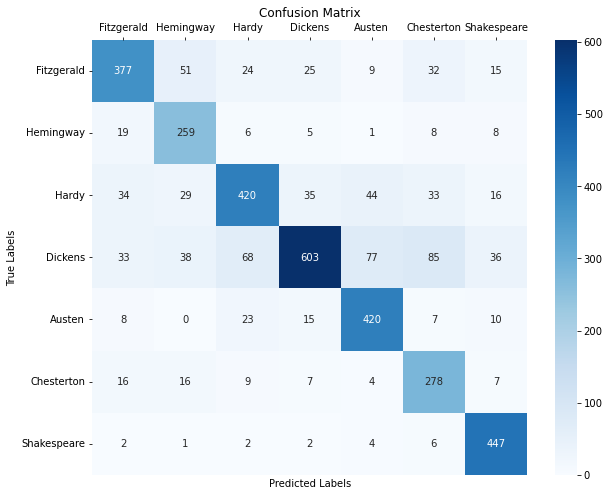

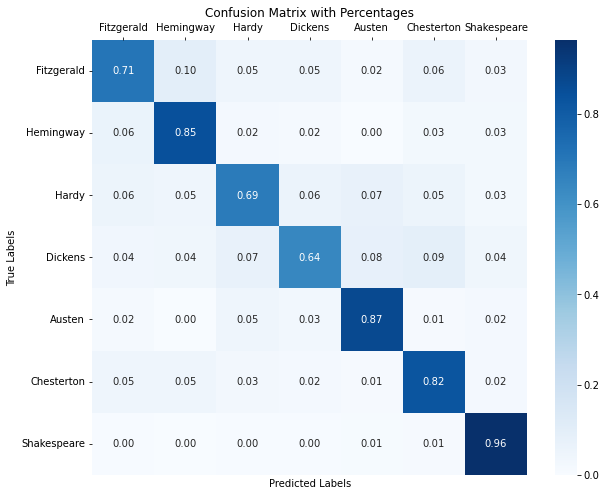

In [129]:
prediction_sgd = sgd_classifier.predict_proba(X_test_tfidf)

# Uncomment to Unit Test
c = create_confusion(test_label_NER, prediction_sgd)
show_confusion(c)

In [137]:
#save_prediction
path = 'D:/MIDS/W266/Project/Prediction/'
file = 'sgd_prediction.csv'
save_prediction(path+file,prediction_sgd)

## Random Forest 

In [131]:
# ###########################################################
# Random Forest Training
# ###########################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

X_train_tfidf = vectorizer.fit_transform(train_data_NER)
X_test_tfidf = vectorizer.transform(test_data_NER)


# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_tfidf, train_label_NER)

RandomForestClassifier(random_state=42)

In [132]:
# ###########################################################
# Random Forest Save Model
# ###########################################################
with open('D:/MIDS/W266/Project/Training/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

with open('D:/MIDS/W266/Project/Training/rf_vec.pkl', 'wb') as f_vec:
    pickle.dump(vectorizer, f_vec)

In [133]:
# ###########################################################
# Random Forest Load & Predict
# ###########################################################
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# *********************************
# ADD LOAD STORED WEIGHTS / MODEL
# *********************************
with open('D:/MIDS/W266/Project/Training/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('D:/MIDS/W266/Project/Training/rf_vec.pkl', 'rb') as f_vec:
    rf_vec = pickle.load(f_vec)

X_test_tfidf = rf_vec.transform(test_data_NER)
prediction_rf = rf_model.predict_proba(X_test_tfidf)

Confusion Matrix:
[[283  85  35  31  24  36  39]
 [ 40 223   3  11   5  16   8]
 [ 67  99 277  32  64  44  28]
 [ 94 102  67 403 128  80  66]
 [ 36  18  30  55 308  16  20]
 [ 31  39   8  21  14 209  15]
 [ 16   5   4   4   7   4 424]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       533
           1       0.39      0.73      0.51       306
           2       0.65      0.45      0.54       611
           3       0.72      0.43      0.54       940
           4       0.56      0.64      0.60       483
           5       0.52      0.62      0.56       337
           6       0.71      0.91      0.80       464

    accuracy                           0.58      3674
   macro avg       0.58      0.62      0.58      3674
weighted avg       0.61      0.58      0.57      3674



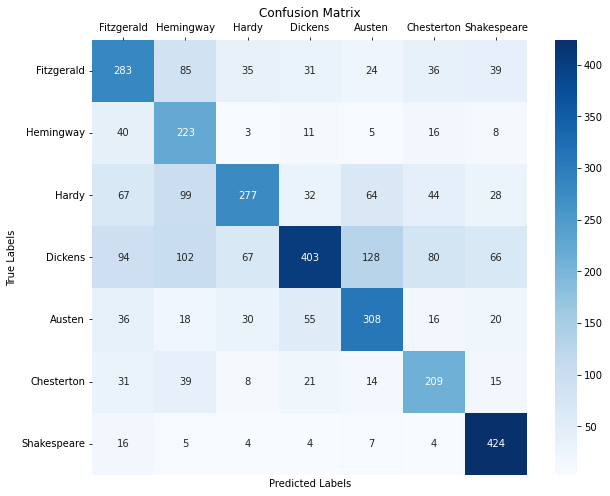

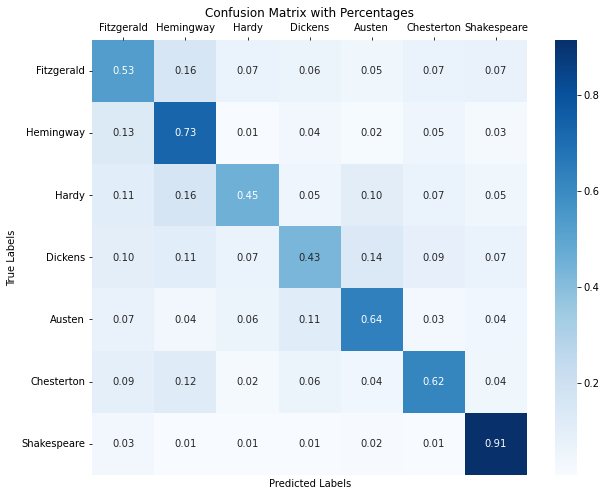

In [134]:
# Uncomment to Unit Test
c = create_confusion(test_label_NER, prediction_rf)
show_confusion(c)

In [136]:
#save_prediction
path = 'D:/MIDS/W266/Project/Prediction/'
file = 'rf_prediction.csv'
save_prediction(path+file,prediction_rf)

## BERT Model 

In [ ]:
# ###########################################################
# BERT Model or Additional Models can go here
# ###########################################################
# ADD ...

# Build Ensembler

In [ ]:
# ###########################################################
# RoBERTa Bin ... Prepare aggregated predictions from binary
# ###########################################################
# ADD ...


In [143]:
# ###########################################################
# Assert prediction sizes are same
# ###########################################################
#assert (len(prediction_roberta_multi) == len(prediction_sgd)) and 
#       (len(prediction_roberta_multi) == len(prediction_rf)),
#       "Prediction lengths do not match"

In [98]:
# ###########################################################
# 
# Given prediction vectors A, B, C,
# want a single vector P = argmax(A,B,C)
# ###########################################################


#num_of_models = 3
#predictions = [prediction_roberta_multi, prediction_sgd, prediction_rf]

#prediction_max1 = []
#prediction_max2 = []
#prediction_max3 = []

# Get the max value from the class probabilities
#for i in range(len(prediction_roberta_multi)):
#    prediction_max1.append(np.argmax(prediction_roberta_multi[i]))
#    prediction_max2.append(np.argmax(prediction_sgd[i]))

#prediction_max = [np.argmax(x) for x in zip(prediction_max1, prediction_max2)]

In [144]:
# ########################################################################
# Compute maximum and average probabilities across the model predictions
# ########################################################################
#prediction_max = [[max(x, y) for x, y in zip(sublist1, sublist2)] 
#                                              for sublist1, sublist2 in zip(prediction_roberta_multi, prediction_sgd)]

prediction_max = [np.maximum(sublist1, sublist2, sublist3) for sublist1, sublist2, sublist3 in 
                  zip(prediction_roberta_multi, prediction_sgd, prediction_rf)]

prediction_avg = [np.average([sublist1, sublist2, sublist3], axis=0) for sublist1, sublist2, sublist3 in 
                  zip(prediction_roberta_multi, prediction_sgd, prediction_rf)]

In [162]:
# ########################################################################
# Compute majority voting on the test class
# ########################################################################
from collections import Counter

#prediction_vote = [np.argmax([sublist1, sublist2, sublist3], axis=0) for sublist1, sublist2, sublist3 in 
#                  zip(prediction_roberta_multi, prediction_sgd, prediction_rf)]

combined_predictions = zip(np.argmax(prediction_roberta_multi, axis=1),
                           np.argmax(prediction_sgd, axis=1),
                           np.argmax(prediction_rf, axis=1))

prediction_vote = [Counter(sublist).most_common(1)[0][0] for sublist in combined_predictions]

In [168]:
prediction_max

[array([0.20052096, 0.06043107, 0.45823929, 0.27220497, 0.19312369,
        0.12896905, 0.02759724]),
 array([0.21969651, 0.62623578, 0.10180195, 0.09967846, 0.02414949,
        0.20907389, 0.01920261]),
 array([0.10212606, 0.04958011, 0.77872205, 0.34522807, 0.01690803,
        0.06654427, 0.01166395]),
 array([0.04726263, 0.013852  , 0.04437529, 0.10119008, 0.96571475,
        0.04769309, 0.00427329]),
 array([0.09528485, 0.04034082, 0.57959121, 0.29934552, 0.30298079,
        0.07648294, 0.01950091]),
 array([0.10775479, 0.04665611, 0.07114712, 0.84436077, 0.04203007,
        0.16123834, 0.08194427]),
 array([0.08355203, 0.04776898, 0.1309887 , 0.02892416, 0.06500819,
        0.07388869, 0.99907982]),
 array([0.19020441, 0.26841136, 0.2615903 , 0.2670773 , 0.07753537,
        0.13612887, 0.11052443]),
 array([0.12163216, 0.16897359, 0.65364838, 0.23360321, 0.11912219,
        0.20091314, 0.04532342]),
 array([0.87028044, 0.05477358, 0.19078777, 0.12047877, 0.02129308,
        0.2027

In [157]:
# UNIT TEST
from collections import Counter

#np.argmax(prediction_rf[0],axis=0)
#print(np.argmax(prediction_roberta_multi[0],axis=0))
#print(np.argmax(prediction_sgd[0],axis=0))
#print(np.argmax(prediction_rf[0],axis=0))
l = [np.argmax(prediction_roberta_multi[0],axis=0),
     np.argmax(prediction_sgd[0],axis=0),
     np.argmax(prediction_rf[0],axis=0)]

Counter(l).most_common(1)[0][0]

2

# Performance Analysis

In [95]:
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[0]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[0]))
print("\nTrue Label: " + str(test_label_NER[0]))
print(test_data_NER[0])
print("\n")
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[1]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[1]))
print("\nTrue Label: " + str(test_label_NER[1]))
print(test_data_NER[1])
print("\n")
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[10]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[10]))
print("\nTrue Label: " + str(test_label_NER[10]))
print(test_data_NER[10])
print("\n")
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[20]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[20]))
print("\nTrue Label: " + str(test_label_NER[20]))
print(test_data_NER[20])
print("\n")
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[30]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[30]))
print("\nTrue Label: " + str(test_label_NER[30]))
print(test_data_NER[30])

RoBERTa class probabilities: [2.5721156e-04 9.9932981e-01 2.5116579e-04 6.8732399e-05 3.0213356e-05
 7.2232788e-06 5.5688321e-05]

SGDClassifier class probabilities:[0.02838983 0.69480068 0.04770453 0.17708596 0.00304997 0.04184162
 0.0071274 ]

True Label: 1
He went out of the room looking  back at the two men at the table. “What’s the matter, ?” set down his glass. “Would you pic two bulls for me to-morrow night?” asked, looking  up at across the table.


RoBERTa class probabilities: [1.5817079e-03 4.4925027e-03 8.6443645e-01 1.2291996e-01 3.7013204e-03
 2.3355000e-03 5.3249422e-04]

SGDClassifier class probabilities:[0.11924114 0.08554571 0.39149716 0.2669485  0.02200264 0.07292069
 0.04184416]

True Label: 2
Pooh. They don’t think much of such as that over there! Lots of  ’em do it… Well, if you take it like that I shall go back to him!


RoBERTa class probabilities: [8.3939340e-03 9.4035995e-01 2.3904776e-02 1.6047508e-02 5.8242646e-03
 7.8873424e-04 4.6807961e-03]

SGDClassifier 

Confusion Matrix:
[[450   8  27  15   1  29   3]
 [ 11 277   3   4   0   5   6]
 [ 11  10 501  22  37  21   9]
 [  8  11 177 562 105  49  28]
 [  0   1  34  19 423   2   4]
 [ 38   5  17  12   1 261   3]
 [  1   0   2   2   1   0 458]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       533
           1       0.89      0.91      0.90       306
           2       0.66      0.82      0.73       611
           3       0.88      0.60      0.71       940
           4       0.74      0.88      0.80       483
           5       0.71      0.77      0.74       337
           6       0.90      0.99      0.94       464

    accuracy                           0.80      3674
   macro avg       0.81      0.83      0.81      3674
weighted avg       0.81      0.80      0.80      3674



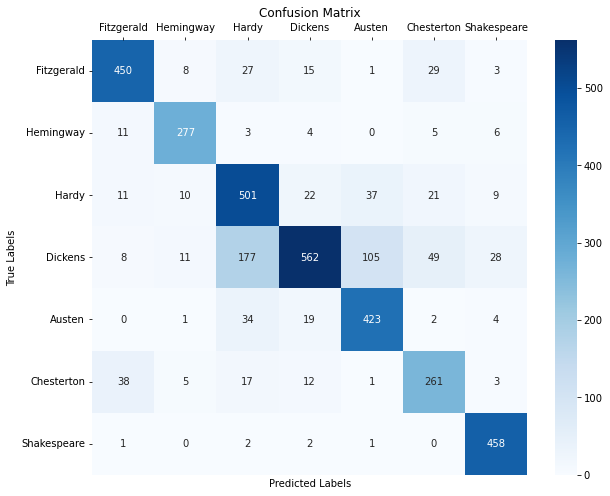

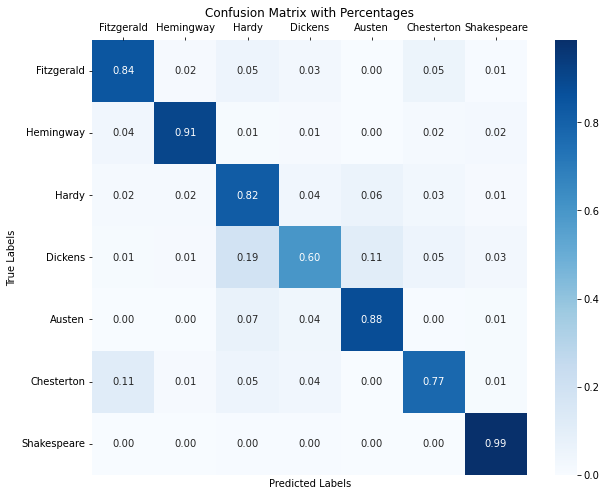

In [170]:
#c_max = create_confusion(test_label_NER, prediction_max)
#show_confusion(c_max)

#c_avg = create_confusion(test_label_NER, prediction_avg)
#show_confusion(c_avg)

c_vote = create_confusion(test_label_NER, prediction_vote,type='class')
show_confusion(c_vote)

In [171]:
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[0]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[0]))
print("\nRandom Forest class probabilities:" + str(prediction_rf[0]))
print("\nTrue Label: " + str(test_label_NER[0]))
print(test_data_NER[0])

RoBERTa class probabilities: [0.079222   0.05902623 0.4582393  0.26657388 0.06456153 0.04477988
 0.02759724]

SGDClassifier class probabilities:[0.20052096 0.06043107 0.13377085 0.27220497 0.19312369 0.12896905
 0.0109794 ]

Random Forest class probabilities:[0.20052096 0.06043107 0.45823929 0.27220497 0.19312369 0.12896905
 0.02759724]

True Label: 0
I’d hate to have him get anything on me.”    This absorbing information about my neighbour was interrupted by Mrs.  McKee’s pointing suddenly at :    “, I think you could do something with her,” she broke out, but  Mr. only nodded in a bored way, and turned his attention to . “I’d like to do more work on Long Island, if I could get the entry. All I ask is that they should give me a start.”    “Ask Myrtle,” said , breaking into a short shout of laughter as  Mrs. entered with a tray.


In [173]:
prediction_avg[0]

array([0.16008798, 0.05996279, 0.35008314, 0.27032794, 0.15026964,
       0.10090599, 0.02205796])

In [179]:
# ############################################################
# Find incorrect matches
# ############################################################
counter=0
for i in range(len(prediction_avg)):
    indx = np.argmax(prediction_avg[i],axis=0)
    if test_label_NER[i] != int(indx):
        counter += 1
        print(i)
        print(test_data_NER[i])
        print("test label: " + str(test_label_NER[i]))
        print("pred label: " + str(indx))
        print("***************************")

print("count: " + str(counter))

0
I’d hate to have him get anything on me.”    This absorbing information about my neighbour was interrupted by Mrs.  McKee’s pointing suddenly at :    “, I think you could do something with her,” she broke out, but  Mr. only nodded in a bored way, and turned his attention to . “I’d like to do more work on Long Island, if I could get the entry. All I ask is that they should give me a start.”    “Ask Myrtle,” said , breaking into a short shout of laughter as  Mrs. entered with a tray.
test label: 0
pred label: 2
***************************
4
Then the greater right I have on my side when I  resolve to do all I can to bring it to an end.”    “All you can, ! Do you think that in these many years no  others have done all they could? Has the difficulty grown easier  because of so many failures?”    “It can’t last for ever,” returned with a fierceness kindling  in him which again presented to me that last sad reminder.
test label: 3
pred label: 2
***************************
11
I’m a soldier’s

In [186]:
print("RoBERTa class probabilities: " + str(prediction_roberta_multi[208]))
print("\nSGDClassifier class probabilities:" + str(prediction_sgd[208]))
print("\nRandom Forest class probabilities:" + str(prediction_rf[208]))
print("\nEnsembler Average probabilities:" + str(prediction_avg[208]))
print("\nEnsembler Max probabilities:" + str(prediction_max[208]))
print("\nEnsembler voting:" + str(prediction_vote[208]))
print("\nTrue Label: " + str(test_label_NER[208]))
print(test_data_NER[208])

RoBERTa class probabilities: [0.1501432  0.20371762 0.13045247 0.20904544 0.11336076 0.11380325
 0.07947725]

SGDClassifier class probabilities:[0.16080738 0.21495064 0.37985119 0.04554999 0.01501138 0.04011505
 0.14371436]

Random Forest class probabilities:[0.16080738 0.21495064 0.37985119 0.20904544 0.11336076 0.11380325
 0.14371436]

Ensembler Average probabilities:[0.15725266 0.2112063  0.29671829 0.15454696 0.08057763 0.08924051
 0.12230199]

Ensembler Max probabilities:[0.16080738 0.21495064 0.37985119 0.20904544 0.11336076 0.11380325
 0.14371436]

Ensembler voting:2

True Label: 1
Yes. Yes. Yes.
